In [1]:
from skimage import io
img_array = io.imread("../image/1200px-STOP_sign.jpg")

In [2]:
img_array.shape

(1296, 1200, 3)

In [3]:
import matplotlib.pyplot as plt

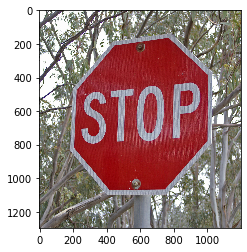

In [4]:
plt.figure()
plt.imshow(img_array)
plt.show()

In [5]:
from torchvision import transforms
import PIL

import copy

composed = transforms.Compose(
    [transforms.Resize((256, 256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def plot_img_from_normalized_img(img_array, is_normalized=True):
    img_to_be_plotted = copy.deepcopy(img_array)
    assert len(img_array.shape) == 3
    if img_to_be_plotted.shape[0] == 3:
        img_to_be_plotted = img_to_be_plotted.transpose(1, 2, 0)
    if is_normalized:
        for idx, (m, v) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
            img_to_be_plotted[:, :, idx] = (img_to_be_plotted[:, :, idx] * v) + m
    plt.figure()
    plt.imshow(img_to_be_plotted)
    plt.show()

In [6]:
transformed_img = composed(PIL.Image.fromarray(img_array))

In [7]:
transformed_img.shape

torch.Size([3, 256, 256])

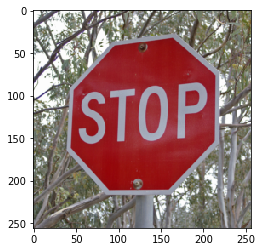

In [8]:
plot_img_from_normalized_img(transformed_img.detach().numpy())

In [9]:
import json

with open("../imagenet_class_index.json") as json_file:
    class_idx = json.load(json_file)

idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [10]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [11]:
torch.manual_seed(0)

In [12]:
class ImageDot(nn.Module):
    def __init__(self):
        super(ImageDot, self).__init__()
        self.means = [0.485, 0.456, 0.406]
        self.stds = [0.229, 0.224, 0.225]
        self.alpha = 0.5
        self.radius = 25.0
        self.beta = 2.0
        self.center = nn.Parameter(torch.tensor([
            [0.25, 0.25], [0.25, 0.5], [0.25, 0.75],
            [0.5, 0.25], [0.5, 0.5], [0.5, 0.75],
            [0.75, 0.25], [0.75, 0.5], [0.75, 0.75]]),
            requires_grad=True)
        self.color = nn.Parameter(torch.tensor([
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5],
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]),
            requires_grad=True)
    
    def forward(self, x):
        _, _, height, width = x.shape
        blended = x
        for idx in range(self.center.shape[0]):
            mask = self._create_circle_mask(height, width, self.center[idx] * 255.0, self.beta)
            normalized_color = self._normalize_color(self.color[idx], self.means, self.stds)
            blended = self._create_blended_img(blended, mask, normalized_color)
        return blended
 
    def _normalize_color(self, color, means, stds):
        return list(map(lambda x, m, s: (x - m) / s, color, means, stds))

    def _create_circle_mask(self, height, width, center, beta):
        hv, wv = torch.meshgrid([torch.arange(0, height), torch.arange(0, width)])
        hv, wv = hv.type(torch.FloatTensor), wv.type(torch.FloatTensor)
        d = ((hv - center[0]) ** 2 + (wv - center[1]) ** 2) / self.radius ** 2
        return torch.exp(- d ** beta + 1e-10)

    def _create_blended_img(self, base, mask, color):
        alpha_tile = mask.expand(3, mask.shape[0], mask.shape[1])
        color_tile = torch.zeros_like(base)
        for c in range(3):
            color_tile[:, c, :, :] = color[c]
        return (1. - alpha_tile) * base + self.alpha * alpha_tile * color_tile


class AttackModel(nn.Module):
    def __init__(self):
        super(AttackModel, self).__init__()
        self.image_dot = ImageDot()
        self.base_model = models.resnet50(pretrained=True).eval()     
        self._freeze_pretrained_model()

    def _freeze_pretrained_model(self):
        for param in self.base_model.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.image_dot(x)
        return self.base_model(x)

In [13]:
model = AttackModel()

In [14]:
pred = model.base_model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-5:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

class: mailbox, idx: 637, logit: 7.9899
class: barn, idx: 425, logit: 7.9944
class: traffic_light, idx: 920, logit: 8.5474
class: water_tower, idx: 900, logit: 9.2191
class: street_sign, idx: 919, logit: 13.6607


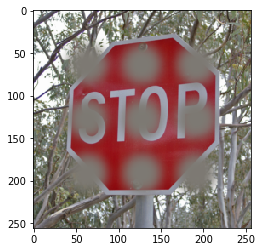

In [15]:
dotted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(dotted_img.squeeze().detach().numpy())

In [16]:
def compute_loss(pred, true_label_idx=919, target_label_idx=402):
    true_label_contrib = F.nll_loss(pred, torch.tensor([true_label_idx]))
    target_label_contrib = F.nll_loss(pred, torch.tensor([target_label_idx]))
    return torch.mean(- true_label_contrib)  # non-targeted
    # return torch.mean(- true_label_contrib + target_label_contrib)  # targeted

In [17]:
lr = 0.0025

In [18]:
loss_function = nn.NLLLoss()

for epoch in range(50):
    model.zero_grad()
    pred = model(transformed_img.unsqueeze(0))
    loss = compute_loss(pred)
    print(loss.data)
    loss.backward(retain_graph=True)
    for param in model.parameters():
        if param.requires_grad == True:
            param.data = torch.clamp(param.data - param.grad.data * lr, min=0.0, max=1.0)

tensor(9.9555)
tensor(9.4663)
tensor(9.9969)
tensor(10.1382)
tensor(10.6452)
tensor(9.8729)
tensor(9.3874)
tensor(9.4342)
tensor(9.1223)
tensor(9.8575)
tensor(8.4093)
tensor(9.5079)
tensor(9.3099)
tensor(8.4777)
tensor(9.2755)
tensor(8.8684)
tensor(9.2066)
tensor(10.0039)
tensor(8.8591)
tensor(9.1852)
tensor(8.8633)
tensor(9.1804)
tensor(9.4329)
tensor(8.8151)
tensor(9.3472)
tensor(9.7147)
tensor(8.2203)
tensor(9.2536)
tensor(8.5125)
tensor(7.8514)
tensor(7.4050)
tensor(8.3438)
tensor(7.8160)
tensor(8.2516)
tensor(8.6030)
tensor(8.6743)
tensor(7.8843)
tensor(7.7467)
tensor(8.2720)
tensor(8.1147)
tensor(7.4078)
tensor(8.6991)
tensor(7.7676)
tensor(8.0622)
tensor(8.1926)
tensor(7.8934)
tensor(8.1190)
tensor(7.7994)
tensor(7.2124)
tensor(7.5233)


In [19]:
for elem in model.parameters():
    if elem.requires_grad == True:
        print(elem, elem.data)

Parameter containing:
tensor([[0.1865, 0.2781],
        [0.1329, 0.5150],
        [0.2637, 0.6592],
        [0.5833, 0.2210],
        [0.5393, 0.6074],
        [0.4174, 0.8331],
        [0.7298, 0.2172],
        [0.5404, 0.3892],
        [0.7437, 0.7364]], requires_grad=True) tensor([[0.1865, 0.2781],
        [0.1329, 0.5150],
        [0.2637, 0.6592],
        [0.5833, 0.2210],
        [0.5393, 0.6074],
        [0.4174, 0.8331],
        [0.7298, 0.2172],
        [0.5404, 0.3892],
        [0.7437, 0.7364]])
Parameter containing:
tensor([[0.6096, 0.4097, 0.5196],
        [0.5035, 0.4875, 0.5464],
        [0.4948, 0.4793, 0.5654],
        [0.5750, 0.4878, 0.4341],
        [0.5451, 0.4454, 0.4948],
        [0.4544, 0.5347, 0.4661],
        [0.4254, 0.5466, 0.5550],
        [0.5800, 0.4138, 0.5296],
        [0.6167, 0.3648, 0.5653]], requires_grad=True) tensor([[0.6096, 0.4097, 0.5196],
        [0.5035, 0.4875, 0.5464],
        [0.4948, 0.4793, 0.5654],
        [0.5750, 0.4878, 0.4341],
   

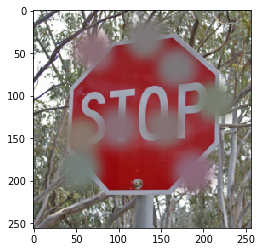

In [20]:
doted_img = model.image_dot(transformed_img.unsqueeze(0))
plot_img_from_normalized_img(doted_img.squeeze().detach().numpy())

In [21]:
# pred = model.base_model(dotted_img)
pred = model(transformed_img.unsqueeze(0))
pred = np.squeeze(pred.detach().numpy())
for elem in np.argsort(pred)[-5:]:
    print(f"class: {idx2label[elem]}, idx: {elem}, logit: {pred[elem]:.4f}")

class: water_tower, idx: 900, logit: 9.2554
class: radio_telescope, idx: 755, logit: 9.5191
class: barn, idx: 425, logit: 10.0272
class: birdhouse, idx: 448, logit: 10.2679
class: mailbox, idx: 637, logit: 10.3264
